# Foliar Disease in Apple

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os
from re import search
import shutil
import natsort
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2


### Import Dataset

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thobelasixpence","key":"97e3bc65c43f113cf8eb0829dd22adf5"}'}

In [4]:
# create a kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
# permission for json files to act
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

 99% 769M/779M [00:30<00:00, 25.8MB/s]
100% 779M/779M [00:30<00:00, 27.1MB/s]


In [7]:
!pip install zip_files

In [8]:
from zipfile import ZipFile
# open the zipped file
file_name="plant-pathology-2020-fgvc7.zip"
with ZipFile(file_name,'r') as zip:
      zip.extractall()
      print('Done')

Done


### Data Directory

In [10]:
# import the dataset for train(labels)
train=pd.read_csv("/content/train.csv")
# import the dataset for test(labels)
test=pd.read_csv("/content/test.csv")

In [12]:
# dirctory for pictures
data_dir = '/content/images'

In [13]:
train.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [14]:
test.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

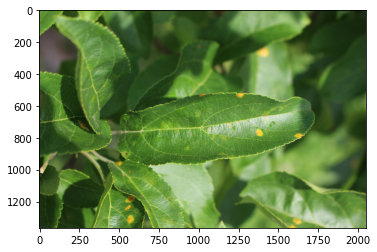

In [16]:
# get the first image just to verify
img_0 = Image.open('/content/images/Test_0.jpg')
plt.imshow(img_0)
plt.show()

## Preparing Data

In [17]:
# get the columns from healthy down to the right
class_names = train.loc[:, 'healthy':].columns
print(class_names)

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [18]:
num = 0
train['label'] = 0
for i in class_names:
  train['label'] = train['label'] + train[i] * num
  num = num+1

In [19]:
print(num)

4


In [20]:
train.head()

image_id  healthy  multiple_diseases  rust  scab  label
0  Train_0        0                  0     0     1      3
1  Train_1        0                  1     0     0      1
2  Train_2        1                  0     0     0      0
3  Train_3        0                  0     1     0      2
4  Train_4        1                  0     0     0      0

In [21]:
data_dir

'/content/images'

In [ ]:
# naturally sort the directory
natsort.natsorted(os.listdir(data_dir))

In [23]:
# we want to get the label of the image since we have four labels which meanss four categories of flowers that our DL model needs to be trained
# on
def get_img_label(img):
  # search forr the string given
  if search("Train", img):
    #split the img and get the first pos
    img = img.split('.')[0]
    # get the labe for the img
    label = train.loc[train['image_id']==img]['label']
    return label


In [37]:
# now we gonna create data for ttraining with the correct categorie of classes found in labels
def create_train_dataset():
  # get all the images that are naturally sorted
  images = natsort.natsorted(os.listdir(data_dir))
  for img in tqdm(images):
    # get the label of the image
    label = get_img_label(img)
    # get path 
    path = os.path.join(data_dir, img)

    if search("Train", img):
      # split the image name because it is named like this image_1.jpg
      if(img.split('_')[1].split('.')[0]) and label.item()==0:
        shutil.copy(path,'/content/train/healthy')

      elif(img.split('_')[1].split('.')[0]) and label.item()==1:
        shutil.copy(path,'/content/train/multiple_diseases')

      elif(img.split('_')[1].split('.')[0]) and label.item()==2:
        shutil.copy(path,'/content/train/rust')

      elif(img.split('_')[1].split('.')[0]) and label.item()==3:
        shutil.copy(path,'/content/train/scab')

    if search("Test", img):
      shutil.copy(path,'/content/test')

In [43]:
shutil.os.mkdir(r'/content/train/')

shutil.os.mkdir(r'/content/train/healthy')
shutil.os.mkdir(r'/content/train/multiple_diseases')
shutil.os.mkdir(r'/content/train/rust')
shutil.os.mkdir(r'/content/train/scab')

shutil.os.mkdir(r'/content/test')

FileExistsError: ignored

In [44]:
train_dir=create_train_dataset()

100%|██████████| 3642/3642 [00:03<00:00, 1157.16it/s]


## Data Preprocessing

In [45]:
train_dir = r'/content/train'
train_dir

'/content/train'

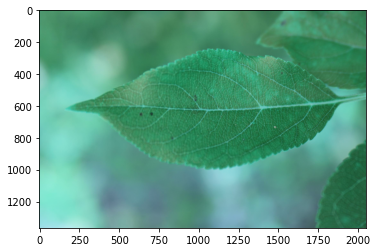

In [46]:
#train_dir = r'Dataset\train'
# categories for classification
categories = ['healthy','multiple_diseases','rust','scab']
# join the path with the category 
for i in categories:
  path = os.path.join(train_dir, i)
  for img in os.listdir(path):
    old_img = cv2.imread(os.path.join(path, img), cv2.COLOR_BGR2RGB)
    plt.imshow(old_img)
    plt.show()
    break
  break

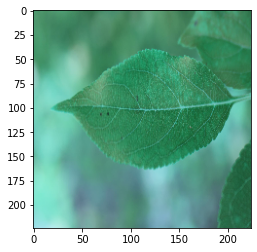

In [48]:
# show a resized image
img_size = 224
new_img = cv2.resize(old_img, (img_size, img_size))
plt.imshow(new_img)
plt.show()

# Model Preparation

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D

In [54]:
# generate data
datagen = ImageDataGenerator(rescale = 1./225,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip = True,
                             validation_split = 0.2)

train_datagen = datagen.flow_from_directory('/content/train',
                                            target_size = (img_size, img_size),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            subset='training')

val_datagen = datagen.flow_from_directory('/content/train',
                                            target_size = (img_size, img_size),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            subset='validation')

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


# Model Building

In [61]:
model= Sequential()
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = (img_size,img_size, 3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

# compiling model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# check the model structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 28, 28, 64)      

# Model Training

In [62]:
checkpoint = ModelCheckpoint('apple_model.h5',
                             monitor = 'val_loss',
                             mode = 'min',
                             save_best_only = True,
                             verbose = 1)

earlystop= EarlyStopping(monitor = 'val_loss',
                          min_delta =0,
                          patience = 10,
                          verbose =1,
                          restore_best_weights=True)

callbacks = [checkpoint, earlystop]

In [63]:
model_history = model.fit_generator(train_datagen, 
                                    validation_data = val_datagen,
                                    epochs = 30,
                                    steps_per_epoch = train_datagen.samples//16,
                                    validation_steps = val_datagen.samples//16,
                                    callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
91/91 [==============================] - ETA: 0s - loss: 1.2876 - accuracy: 0.3037
Epoch 1: val_loss improved from inf to 1.23614, saving model to apple_model.h5
91/91 [==============================] - 74s 799ms/step - loss: 1.2876 - accuracy: 0.3037 - val_loss: 1.2361 - val_accuracy: 0.3381
Epoch 2/30
91/91 [==============================] - ETA: 0s - loss: 1.2489 - accuracy: 0.3197
Epoch 2: val_loss did not improve from 1.23614
91/91 [==============================] - 77s 853ms/step - loss: 1.2489 - accuracy: 0.3197 - val_loss: 1.2411 - val_accuracy: 0.3352
Epoch 3/30
91/91 [==============================] - ETA: 0s - loss: 1.2394 - accuracy: 0.3738
Epoch 3: val_loss did not improve from 1.23614
91/91 [==============================] - 71s 777ms/step - loss: 1.2394 - accuracy: 0.3738 - val_loss: 1.2389 - val_accuracy: 0.3352
Epoch 4/30
91/91 [==============================] - ETA: 0s - loss: 1.0786 - accuracy: 0.4979
Epoch 4: val_loss improved from 1.23614 to 0.90296, sav

# Model Evaluation

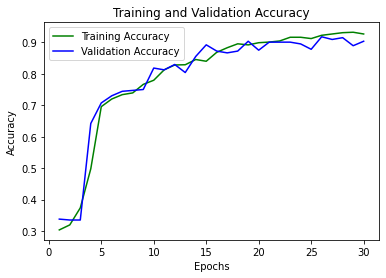

In [64]:
train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs,train_acc,'g',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

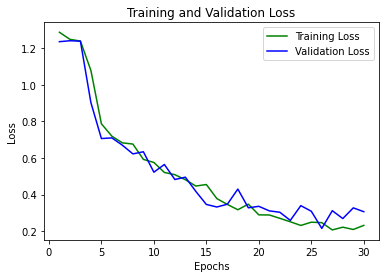

In [65]:
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
epochs=range(1,31)
plt.plot(epochs,train_loss,'g',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Model Prediction

2


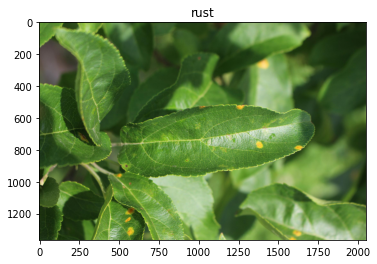

In [67]:
# get the image
test_img = '/content/test/Test_0.jpg'
img_pred = Image.open(test_img) 
from tensorflow.keras.preprocessing import image
test_img=image.load_img(test_img,target_size=(224,224))
test_img=image.img_to_array(test_img)
test_img=test_img/255
test_img=np.expand_dims(test_img,axis=0)
result=model.predict(test_img)
print(np.argmax(result))

Categories=['healthy','multiple_disease','rust','scab']
image_result=plt.imshow(img_pred)
plt.title(Categories[np.argmax(result)])
plt.show()

#Save Model

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
tf.keras.models.save_model(model,'/content/gdrive/MyDrive/apple_model.h5')